# CHAPTER 07. 시계열수치입력 수치 예측 모델 레시피

각 모델에 코사인(cosine) 데이터를 학습시킨 후, 처음 일부 데이터를 알려주면 이후 코사인 형태의 데이터를 얼마나 잘 예측하는지 테스트해보자.

In [1]:
# 사용할 패키지 불러오기
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
%matplotlib inline

Using TensorFlow backend.


In [2]:
# 먼저 코사인 데이터를 만들어보자.
#  -1.0 에서 1.0 사이로 변하는 1600 개의 실수값을 생성한다.
signal_data = np.cos(np.arange(1600) * (20 * np.pi / 1000))[:, None]

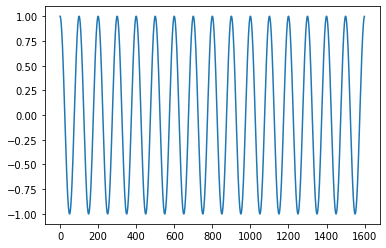

In [3]:
# 생성한 데이터를 확인해보자.
plot_x = np.arange(1600)
plot_y = signal_data
plt.plot(plot_x, plot_y)
plt.show()

시계열 수치 예측은 이전 수치들을 입력하여 다음 수치를 예측하는 문제이므로 **데이터는 이전 수치들이 되고, 라벨은 다음 수치가 된다**

In [4]:
# 학습을 위해서 데이터와 라벨로 구성된 데이터셋을 만드는 함수를 작성해보자.
#  lock_back : 얼마만큼의 이전 수치를 데이터를 만들 것 인가를 결정한다.
def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data) - look_back):
        dataX.append(signal_data[i : (i + look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

<br>

-1.0 에서 1.0 까지의 값을 가지는 코사인 데이터를 0.0과 1.0 사이의 값을 가지도록 **정규화를** 한 뒤 훈련셋과 시험셋으로 분리한다.

In [5]:
look_back = 40

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
signal_data = scaler.fit_transform(signal_data)

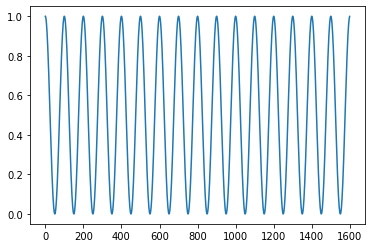

In [6]:
# 생성한 데이터를 확인해보자.
plot_x = np.arange(1600)
plot_y = signal_data
plt.plot(plot_x, plot_y)
plt.show()

In [7]:
# 데이터 분리
train = signal_data[0:800]
val = signal_data[800:1200]
test = signal_data[1200:]

In [8]:
# 데이터셋 생성
x_train, y_train = create_dataset(train, look_back)
x_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

In [9]:
print('=== x_train[0] ===')
print(x_train[0])
print()
print('=== x_train[1] ===')
print(x_train[1])

=== x_train[0] ===
[1.         0.99901336 0.99605735 0.99114363 0.98429158 0.97552826
 0.96488824 0.95241353 0.93815334 0.92216396 0.9045085  0.88525662
 0.86448431 0.84227355 0.81871199 0.79389263 0.7679134  0.74087684
 0.71288965 0.68406228 0.6545085  0.62434494 0.59369066 0.56266662
 0.53139526 0.5        0.46860474 0.43733338 0.40630934 0.37565506
 0.3454915  0.31593772 0.28711035 0.25912316 0.2320866  0.20610737
 0.18128801 0.15772645 0.13551569 0.11474338]

=== x_train[1] ===
[0.99901336 0.99605735 0.99114363 0.98429158 0.97552826 0.96488824
 0.95241353 0.93815334 0.92216396 0.9045085  0.88525662 0.86448431
 0.84227355 0.81871199 0.79389263 0.7679134  0.74087684 0.71288965
 0.68406228 0.6545085  0.62434494 0.59369066 0.56266662 0.53139526
 0.5        0.46860474 0.43733338 0.40630934 0.37565506 0.3454915
 0.31593772 0.28711035 0.25912316 0.2320866  0.20610737 0.18128801
 0.15772645 0.13551569 0.11474338 0.0954915 ]


In [10]:
print(y_train[0])

0.09549150281252633


> y_train\[0\]은 x_train\[0\]을 통해 그 다음 값을 라벨로 하는데, x_train\[1\]을 확인해보면 맨 뒤에 새롭게 추가된 값과 같은 것을 확인 할 수 있다.

<br>

---

<br>

# 모델 준비
## 다층퍼셉트론 모델
<img src="http://tykimos.github.io/warehouse/2017-9-9-Time-series_Numerical_Input_Numerical_Prediction_Model_Recipe_1m.png">

In [11]:
# 은닉층은 relu 활성화 함수를 사용하여 구성하였다.
# 또한, 과적합을 방지하기 위해 Dropout 레이어가 삽입된다.
model = Sequential()
model.add(Dense(32, input_dim=40, activation='relu'))
model.add(Dropout(0.3))
for i in range(2):
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.3))
model.add(Dense(1))

In [12]:
# 딥러닝 모델 가시화
def visualize(model):
    return SVG(model_to_dot(model, show_shapes=True, dpi=65)
               .create(prog='dot', format='svg'))

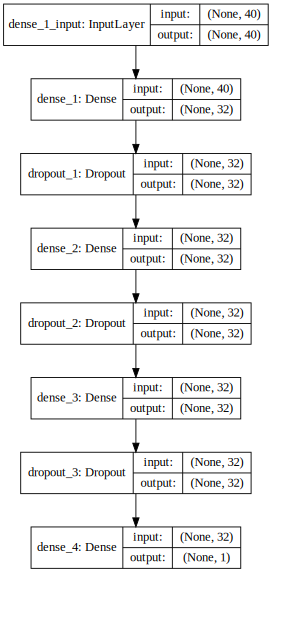

In [13]:
visualize(model)

In [14]:
# 모델 학습과정 설정하기
#  mean_squared_error(mse) : 손실 함수
#  sdagrad : 최적화 알고리즘
model.compile(loss='mean_squared_error', optimizer='adagrad')

### MSE (Mean Squared Error)

<img src="https://mblogthumb-phinf.pstatic.net/MjAxNzA2MTBfMjUw/MDAxNDk3MDc3OTEzMzA4.T8Tib6FnZh-UsHxRQLA1pwrJ1MZCI_K6zEXG7WBpYt4g.4lPx7q8sxWKiz-9nsFLADl9baLIsNja2Z4k3xnkc2aog.JPEG.wideeyed/CEE1.jpg?type=w2">

> 값이 작을 수록 정답에 가깝다고 측정하는 손실 함수이다.

<br><br>

### AdaGrad (Adaptive Gradient)

<img src="http://i.imgur.com/pD0hWu5.gif?1">

> Adagrad(Adaptive Gradient)는 변수들을 update할 때 각각의 변수마다 step size를 다르게 설정해서 이동하는 방식이다.

In [15]:
# 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=200, batch_size=32,
                validation_data=(x_val, y_val))

Train on 760 samples, validate on 360 samples
Epoch 1/200
760/760 [==============================] - 0s 407us/step - loss: 0.1510 - val_loss: 0.0162
Epoch 2/200
760/760 [==============================] - 0s 56us/step - loss: 0.0652 - val_loss: 0.0103
Epoch 3/200
760/760 [==============================] - 0s 64us/step - loss: 0.0545 - val_loss: 0.0155
Epoch 4/200
760/760 [==============================] - 0s 57us/step - loss: 0.0419 - val_loss: 0.0137
Epoch 5/200
760/760 [==============================] - 0s 57us/step - loss: 0.0390 - val_loss: 0.0179
Epoch 6/200
760/760 [==============================] - 0s 59us/step - loss: 0.0356 - val_loss: 0.0072
Epoch 7/200
760/760 [==============================] - 0s 64us/step - loss: 0.0286 - val_loss: 0.0065
Epoch 8/200
760/760 [==============================] - 0s 64us/step - loss: 0.0292 - val_loss: 0.0100
Epoch 9/200
760/760 [==============================] - 0s 69us/step - loss: 0.0244 - val_loss: 0.0049
Epoch 10/200
760/760 [=============

760/760 [==============================] - 0s 41us/step - loss: 0.0118 - val_loss: 0.0070
Epoch 81/200
760/760 [==============================] - 0s 40us/step - loss: 0.0109 - val_loss: 0.0065
Epoch 82/200
760/760 [==============================] - 0s 41us/step - loss: 0.0111 - val_loss: 0.0082
Epoch 83/200
760/760 [==============================] - 0s 40us/step - loss: 0.0122 - val_loss: 0.0072
Epoch 84/200
760/760 [==============================] - 0s 44us/step - loss: 0.0132 - val_loss: 0.0082
Epoch 85/200
760/760 [==============================] - 0s 39us/step - loss: 0.0105 - val_loss: 0.0075
Epoch 86/200
760/760 [==============================] - 0s 42us/step - loss: 0.0105 - val_loss: 0.0080
Epoch 87/200
760/760 [==============================] - 0s 43us/step - loss: 0.0096 - val_loss: 0.0072
Epoch 88/200
760/760 [==============================] - 0s 40us/step - loss: 0.0109 - val_loss: 0.0077
Epoch 89/200
760/760 [==============================] - 0s 44us/step - loss: 0.0111 - 

760/760 [==============================] - 0s 59us/step - loss: 0.0095 - val_loss: 0.0069
Epoch 160/200
760/760 [==============================] - 0s 51us/step - loss: 0.0084 - val_loss: 0.0069
Epoch 161/200
760/760 [==============================] - 0s 59us/step - loss: 0.0096 - val_loss: 0.0069
Epoch 162/200
760/760 [==============================] - 0s 51us/step - loss: 0.0098 - val_loss: 0.0062
Epoch 163/200
760/760 [==============================] - 0s 51us/step - loss: 0.0090 - val_loss: 0.0068
Epoch 164/200
760/760 [==============================] - 0s 57us/step - loss: 0.0093 - val_loss: 0.0072
Epoch 165/200
760/760 [==============================] - 0s 50us/step - loss: 0.0097 - val_loss: 0.0067
Epoch 166/200
760/760 [==============================] - 0s 49us/step - loss: 0.0095 - val_loss: 0.0073
Epoch 167/200
760/760 [==============================] - 0s 49us/step - loss: 0.0099 - val_loss: 0.0075
Epoch 168/200
760/760 [==============================] - 0s 45us/step - loss: 

In [16]:
# 학습과정 살펴보기
def review(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.ylim(0.0, 0.15)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

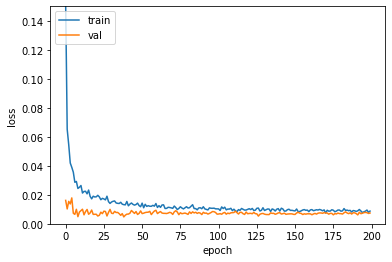

In [17]:
review(hist)

In [18]:
# 모델 평가하기
           
# 훈련셋 평가
trainScore = model.evaluate(x_train, y_train, verbose=0)
print('Train Score:', trainScore)     

# 검증셋 평가
valScore = model.evaluate(x_val, y_val, verbose=0)
print('Validation Score:', valScore)  

# 시험셋 평가
testScore = model.evaluate(x_test, y_test, verbose=0)
print('Test Score:', testScore)

Train Score: 0.007311126937795626
Validation Score: 0.007434996734890673
Test Score: 0.007434996734890673


In [19]:
print(x_test[0])
print(y_test[0])

[1.         0.99901336 0.99605735 0.99114363 0.98429158 0.97552826
 0.96488824 0.95241353 0.93815334 0.92216396 0.9045085  0.88525662
 0.86448431 0.84227355 0.81871199 0.79389263 0.7679134  0.74087684
 0.71288965 0.68406228 0.6545085  0.62434494 0.59369066 0.56266662
 0.53139526 0.5        0.46860474 0.43733338 0.40630934 0.37565506
 0.3454915  0.31593772 0.28711035 0.25912316 0.2320866  0.20610737
 0.18128801 0.15772645 0.13551569 0.11474338]
0.09549150281252716


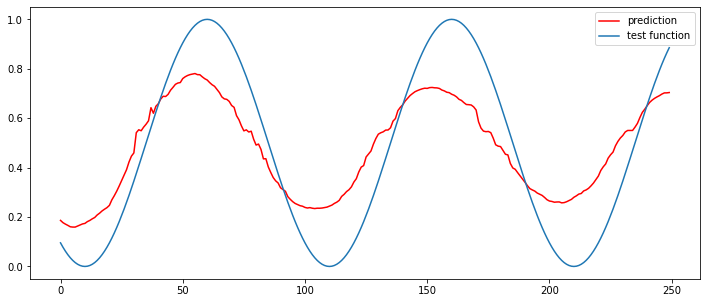

In [20]:
# 모델 사용하기
look_ahead = 250
xhat = x_test[0, None]
predictions = np.zeros((look_ahead, 1))
for i in range(look_ahead):
    prediction = model.predict(xhat, batch_size=32)
    predictions[i] = prediction
    xhat = np.hstack([xhat[:, 1:], prediction])

plt.figure(figsize=(12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label='prediction')
plt.plot(np.arange(look_ahead), y_test[:look_ahead], label='test function')
plt.legend()
plt.show()

In [21]:
xhat = x_test[0, None]
print(len(xhat[0]))
print(xhat[0])
prediction = model.predict(xhat, batch_size=32)
print(prediction)
xhat = np.hstack([xhat[:, 1:], prediction])
print(len(xhat[0]))
print(xhat)

40
[1.         0.99901336 0.99605735 0.99114363 0.98429158 0.97552826
 0.96488824 0.95241353 0.93815334 0.92216396 0.9045085  0.88525662
 0.86448431 0.84227355 0.81871199 0.79389263 0.7679134  0.74087684
 0.71288965 0.68406228 0.6545085  0.62434494 0.59369066 0.56266662
 0.53139526 0.5        0.46860474 0.43733338 0.40630934 0.37565506
 0.3454915  0.31593772 0.28711035 0.25912316 0.2320866  0.20610737
 0.18128801 0.15772645 0.13551569 0.11474338]
[[0.1863769]]
40
[[0.99901336 0.99605735 0.99114363 0.98429158 0.97552826 0.96488824
  0.95241353 0.93815334 0.92216396 0.9045085  0.88525662 0.86448431
  0.84227355 0.81871199 0.79389263 0.7679134  0.74087684 0.71288965
  0.68406228 0.6545085  0.62434494 0.59369066 0.56266662 0.53139526
  0.5        0.46860474 0.43733338 0.40630934 0.37565506 0.3454915
  0.31593772 0.28711035 0.25912316 0.2320866  0.20610737 0.18128801
  0.15772645 0.13551569 0.11474338 0.1863769 ]]


<br>

---

<br>

# 모델 준비
## 순환신경망 모델

<img src="http://tykimos.github.io/warehouse/2017-9-9-Time-series_Numerical_Input_Numerical_Prediction_Model_Recipe_2m.png">

* 한 개의 LSTM 레이어를 이용하여 순환신경망 모델을 구성
* 출력층은 하나의 수치값을 예측하기 위해 1개 뉴런을 가진 Dense 레이어를 사용

In [22]:
# 데이터셋 생성
x_train, y_train = create_dataset(train, look_back)
x_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

In [24]:
# 데이터셋 전처리
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [25]:
print(x_train[0])
print(len(x_train))
print(len(x_train[0]))
print(len(x_train[0][0]))

[[1.        ]
 [0.99901336]
 [0.99605735]
 [0.99114363]
 [0.98429158]
 [0.97552826]
 [0.96488824]
 [0.95241353]
 [0.93815334]
 [0.92216396]
 [0.9045085 ]
 [0.88525662]
 [0.86448431]
 [0.84227355]
 [0.81871199]
 [0.79389263]
 [0.7679134 ]
 [0.74087684]
 [0.71288965]
 [0.68406228]
 [0.6545085 ]
 [0.62434494]
 [0.59369066]
 [0.56266662]
 [0.53139526]
 [0.5       ]
 [0.46860474]
 [0.43733338]
 [0.40630934]
 [0.37565506]
 [0.3454915 ]
 [0.31593772]
 [0.28711035]
 [0.25912316]
 [0.2320866 ]
 [0.20610737]
 [0.18128801]
 [0.15772645]
 [0.13551569]
 [0.11474338]]
760
40
1


In [26]:
# 모델 구성하기
LSTM_model = Sequential()
LSTM_model.add(LSTM(32, input_shape=(None, 1)))
LSTM_model.add(Dropout(0.3))
LSTM_model.add(Dense(1))

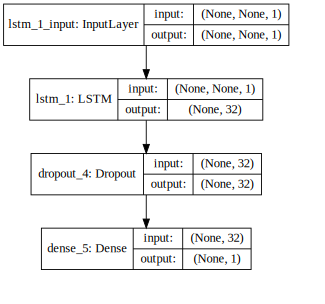

In [27]:
visualize(LSTM_model)

In [28]:
# 모델 학습과정 설정하기
#  adam : 학습률을 줄여나가고 속도를 계산하여 학습의 갱신강도를 적응적으로 조정해나가는 최적화 함수
LSTM_model.compile(loss='mean_squared_error', optimizer='adam')

In [29]:
# 모델 학습시키기
LSTM_hist = LSTM_model.fit(x_train, y_train, epochs=200, 
                           batch_size=32, validation_data=(x_val, y_val))

Train on 760 samples, validate on 360 samples
Epoch 1/200
760/760 [==============================] - 1s 1ms/step - loss: 0.2134 - val_loss: 0.0635
Epoch 2/200
760/760 [==============================] - 0s 585us/step - loss: 0.0557 - val_loss: 0.0316
Epoch 3/200
760/760 [==============================] - 0s 619us/step - loss: 0.0325 - val_loss: 0.0160
Epoch 4/200
760/760 [==============================] - 0s 590us/step - loss: 0.0192 - val_loss: 0.0026
Epoch 5/200
760/760 [==============================] - 0s 594us/step - loss: 0.0111 - val_loss: 0.0019
Epoch 6/200
760/760 [==============================] - 0s 608us/step - loss: 0.0099 - val_loss: 0.0018
Epoch 7/200
760/760 [==============================] - 0s 560us/step - loss: 0.0078 - val_loss: 4.7795e-04
Epoch 8/200
760/760 [==============================] - 0s 567us/step - loss: 0.0073 - val_loss: 0.0010
Epoch 9/200
760/760 [==============================] - 0s 543us/step - loss: 0.0070 - val_loss: 2.2933e-04
Epoch 10/200
760/760 

Epoch 77/200
760/760 [==============================] - 0s 495us/step - loss: 0.0032 - val_loss: 1.4123e-04
Epoch 78/200
760/760 [==============================] - 0s 491us/step - loss: 0.0029 - val_loss: 9.0288e-05
Epoch 79/200
760/760 [==============================] - 0s 525us/step - loss: 0.0030 - val_loss: 1.1837e-04
Epoch 80/200
760/760 [==============================] - 0s 535us/step - loss: 0.0031 - val_loss: 2.3349e-04
Epoch 81/200
760/760 [==============================] - 0s 514us/step - loss: 0.0029 - val_loss: 3.0863e-04
Epoch 82/200
760/760 [==============================] - 0s 609us/step - loss: 0.0028 - val_loss: 3.6588e-05
Epoch 83/200
760/760 [==============================] - 0s 552us/step - loss: 0.0030 - val_loss: 2.6192e-04
Epoch 84/200
760/760 [==============================] - 1s 683us/step - loss: 0.0029 - val_loss: 1.0484e-04
Epoch 85/200
760/760 [==============================] - 0s 581us/step - loss: 0.0031 - val_loss: 3.9578e-05
Epoch 86/200
760/760 [======

760/760 [==============================] - 0s 562us/step - loss: 0.0020 - val_loss: 4.5305e-05
Epoch 153/200
760/760 [==============================] - 0s 551us/step - loss: 0.0019 - val_loss: 5.8494e-05
Epoch 154/200
760/760 [==============================] - 0s 553us/step - loss: 0.0021 - val_loss: 1.8141e-05
Epoch 155/200
760/760 [==============================] - 0s 558us/step - loss: 0.0018 - val_loss: 1.0077e-04
Epoch 156/200
760/760 [==============================] - 0s 560us/step - loss: 0.0021 - val_loss: 1.2897e-04
Epoch 157/200
760/760 [==============================] - 0s 560us/step - loss: 0.0018 - val_loss: 4.3813e-04
Epoch 158/200
760/760 [==============================] - 0s 548us/step - loss: 0.0020 - val_loss: 1.4503e-04
Epoch 159/200
760/760 [==============================] - 0s 555us/step - loss: 0.0017 - val_loss: 1.3083e-04
Epoch 160/200
760/760 [==============================] - 0s 552us/step - loss: 0.0019 - val_loss: 1.3840e-04
Epoch 161/200
760/760 [==========

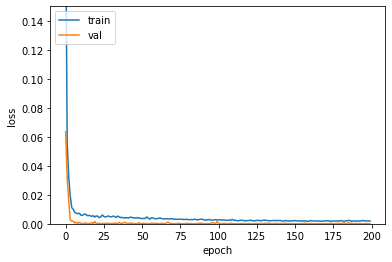

In [30]:
# 학습과정 살펴보기
review(LSTM_hist)

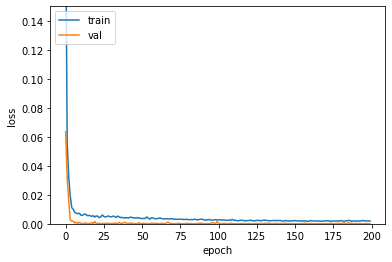

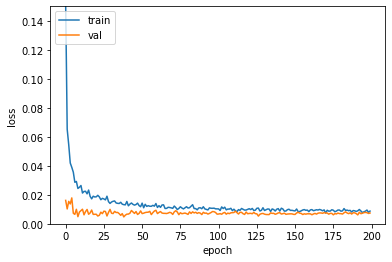

In [31]:
# 순환신경망과 다층퍼셉트론 학습 차이
review(LSTM_hist)
review(hist)

In [32]:
# 모델 평가하기
trainScore = LSTM_model.evaluate(x_train, y_train, verbose=0)
LSTM_model.reset_states()
print('Train Score:', trainScore)
valScore = LSTM_model.evaluate(x_val, y_val, verbose=0)
LSTM_model.reset_states()
print('Validataion Score:', valScore)
testScore = LSTM_model.evaluate(x_test, y_test, verbose=0)
LSTM_model.reset_states()
print('Test Score:', testScore)

Train Score: 0.00011481065854528233
Validataion Score: 0.0001136962353484705
Test Score: 0.0001136962353484705


In [33]:
print('=== x_test[0] ===')
print(x_test[0])
print('\n=== y_test[0] ===')
print(y_test[0])
print('\n=== x_test[1] ===')
print(x_test[1])

=== x_test[0] ===
[[1.        ]
 [0.99901336]
 [0.99605735]
 [0.99114363]
 [0.98429158]
 [0.97552826]
 [0.96488824]
 [0.95241353]
 [0.93815334]
 [0.92216396]
 [0.9045085 ]
 [0.88525662]
 [0.86448431]
 [0.84227355]
 [0.81871199]
 [0.79389263]
 [0.7679134 ]
 [0.74087684]
 [0.71288965]
 [0.68406228]
 [0.6545085 ]
 [0.62434494]
 [0.59369066]
 [0.56266662]
 [0.53139526]
 [0.5       ]
 [0.46860474]
 [0.43733338]
 [0.40630934]
 [0.37565506]
 [0.3454915 ]
 [0.31593772]
 [0.28711035]
 [0.25912316]
 [0.2320866 ]
 [0.20610737]
 [0.18128801]
 [0.15772645]
 [0.13551569]
 [0.11474338]]

=== y_test[0] ===
0.09549150281252716

=== x_test[1] ===
[[0.99901336]
 [0.99605735]
 [0.99114363]
 [0.98429158]
 [0.97552826]
 [0.96488824]
 [0.95241353]
 [0.93815334]
 [0.92216396]
 [0.9045085 ]
 [0.88525662]
 [0.86448431]
 [0.84227355]
 [0.81871199]
 [0.79389263]
 [0.7679134 ]
 [0.74087684]
 [0.71288965]
 [0.68406228]
 [0.6545085 ]
 [0.62434494]
 [0.59369066]
 [0.56266662]
 [0.53139526]
 [0.5       ]
 [0.46860474]

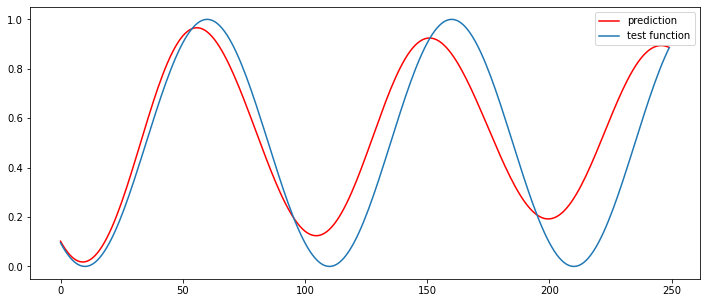

In [34]:
# 모델 사용하기
look_ahead = 250
xhat = x_test[0]
predictions = np.zeros((look_ahead, 1))
for i in range(look_ahead):
    prediction = LSTM_model.predict(np.array([xhat]), batch_size=1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:], prediction])

plt.figure(figsize=(12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label='prediction')
plt.plot(np.arange(look_ahead), y_test[:look_ahead], label='test function')
plt.legend()
plt.show()

### 다층퍼셉트론 모델 사용 결과
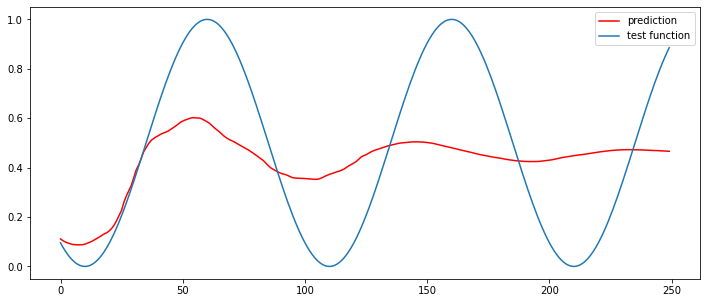

<br>

---

<br>

# 모델 준비
## 상태유지 순환신경망 모델

<img src="http://tykimos.github.io/warehouse/2017-9-9-Time-series_Numerical_Input_Numerical_Prediction_Model_Recipe_3m.png">

* 이전의 순환신경망과 모델과 동일하나 **'stateful = True'** 옵션을 사용하여 상태유지 가능한 순환신경망 모델을 구성
* 상태유지 모드일 경우 한 배치에서 학습된 상태가 다음 배치 학습 시에 전달되는 방식이다.

In [35]:
# 커스텀 콜백 클래스 및 함수 생성
import keras
class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

In [36]:
# 데이터 생성
x_train, y_train = create_dataset(train, lock_back)
x_val, y_val = create_dataset(val, lock_back)
x_test, y_test = create_dataset(test, lock_back)

# 데이터 전처리
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

NameError: name 'lock_back' is not defined

In [ ]:
# 모델 구성하기
stateful_LSTM_model = Sequential()
stateful_LSTM_model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True))
stateful_LSTM_model.add(Dropout(0.3))
stateful_LSTM_model.add(Dense(1))

In [ ]:
visualize(LSTM_model)

In [ ]:
visualize(stateful_LSTM_model)

In [ ]:
# 모델 학습과정 설정하기
stateful_LSTM_model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# 모델 학습시키기
custom_hist = CustomHistory()
custom_hist.init()

for i in range(200):
    stateful_LSTM_model.fit(x_train, y_train, epochs=1, batch_size=1, shuffle=False,
                           callbacks=[custom_hist], validation_data=(x_val, y_val))
    stateful_LSTM_model.reset_states()

* 학습중 평가 손실이 갑자기 오르는 현상?

In [ ]:
# 학습과정 살펴보기
plt.plot(custom_hist.train_loss)
plt.plot(custom_hist.val_loss)
plt.ylim(0.0, 0.1)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# 모델 평가하기
trainScore = stateful_LSTM_model.evaluate(x_train, y_train, batch_size=1, verbose=0)
stateful_LSTM_model.reset_states()
print('Train Score:', trainScore)
valScore = stateful_LSTM_model.evaluate(x_val, y_val, batch_size=1, verbose=0)
stateful_LSTM_model.reset_states()
print('Validation Score:', valScore)
testScore = stateful_LSTM_model.evaluate(x_test, y_test, batch_size=1, verbose=0)
stateful_LSTM_model.reset_states()
print('Test Score:', testScore)

Train Score: 0.0002102212654120338
Validataion Score: 0.0002103805516122116
Test Score: 0.0002103805516122116

In [ ]:
# 모델 사용하기
lock_ahead = 250
xhat = x_test[0]
predictions = np.zeros((lock_ahead, 1))
for i in range(lock_ahead):
    prediction = stateful_LSTM_model.predict(np.array([xhat]), batch_size=1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:], prediction])

plt.figure(figsize=(12, 5))
plt.plot(np.arange(lock_ahead), predictions, 'r', label='prediction')
plt.plot(np.arange(lock_ahead), y_test[:look_ahead], label='test function')
plt.legend()
plt.show()

<br>

---

<br>

# 모델 준비
## 상태유지 스택 순환신경망 모델

<img src="http://tykimos.github.io/warehouse/2017-9-9-Time-series_Numerical_Input_Numerical_Prediction_Model_Recipe_4m.png">

* 상태유지 순환신경망을 여러겹 쌓아올린 모델
* 층이 하나인 순환신경망에 비해 더 깊은 추론이 가능한 모델이다.

In [ ]:
# 모델 구성하기
LSTM_stack_model = Sequential()
for i in range(2):
    # return_squences : 시퀀스 출력 여부, 마지막 시퀀스에서 한 번만 출력할 수 있고 각 시퀀스에서 출력할 수 있다.
    # stateful : 상태 유지 여부, 
    LSTM_stack_model.add(LSTM(32, batch_input_shape=(1, lock_back, 1), stateful=True,
                              return_sequences=True))
    LSTM_stack_model.add(Dropout(0.3))
LSTM_stack_model.add(LSTM(32, batch_input_shape=(1, lock_back, 1), stateful=True))
LSTM_stack_model.add(Dropout(0.3))
LSTM_stack_model.add(Dense(1))

In [ ]:
visualize(LSTM_stack_model)

In [ ]:
LSTM_stack_model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# 모델 학습시키기
custom_hist3 = CustomHistory()
custom_hist3.init()

for i in range(200):
    print('=== train:', i, '===')
    LSTM_stack_model.fit(x_train, y_train, epochs=1, batch_size=1, shuffle=False, 
                         verbose=2, callbacks=[custom_hist3],
                         validation_data=(x_val, y_val))
    LSTM_stack_model.reset_states()

In [ ]:
# 학습과정 살펴보기
plt.plot(custom_hist3.train_loss)
plt.plot(custom_hist3.val_loss)
plt.ylim(0.0, 0.15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# 모델 평가하기
trainScore = LSTM_stack_model.evaluate(x_train, y_train, batch_size=1, verbose=0)
LSTM_stack_model.reset_states()
print('Train Score:', trainScore)
valScore = LSTM_stack_model.evaluate(x_val, y_val, batch_size=1, verbose=0)
LSTM_stack_model.reset_states()
print('Validataion Score:', valScore)
testScore = LSTM_stack_model.evaluate(x_test, y_test, batch_size=1, verbose=0)
LSTM_stack_model.reset_states()
print('Test Score:', testScore)

In [ ]:
# 모델 사용하기
look_ahead = 250
xhat = x_test[0]
predictions = np.zeros((look_ahead, 1))
for i in range(look_ahead):
    prediction = LSTM_stack_model.predict(np.array([xhat]), batch_size=1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:], prediction])

plt.figure(figsize=(12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label='prediction')
plt.plot(np.arange(look_ahead), y_test[:look_ahead], label='test function')
plt.legend()
plt.show()

<br>

# 학습결과 비교

## 다층퍼셉트론
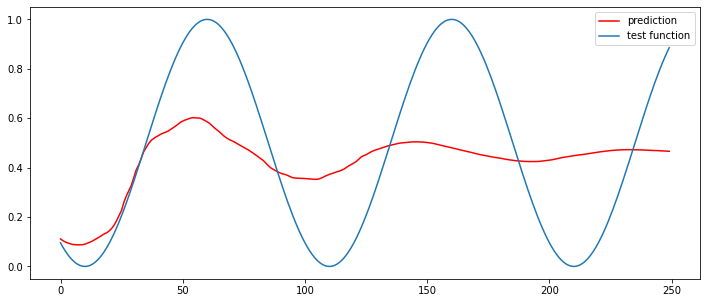

<br>

## 순환신경망
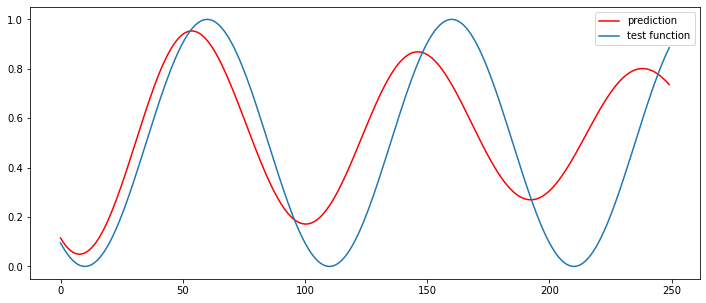

<br>

## 상태유지 순환신경망
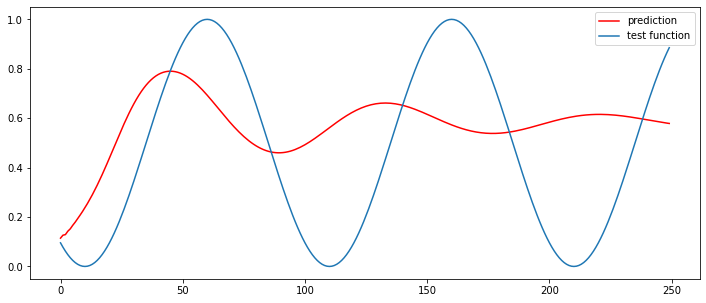

<br>

## 상태유지 스택 순환신경망

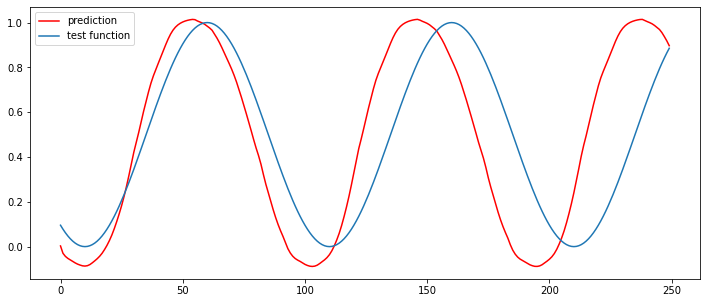